In [1]:
#Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

#LSTM RNN
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

#Check for stationarity
from sklearn.metrics import mean_squared_error

plt.style.use('seaborn-darkgrid')


Using TensorFlow backend.


In [2]:
#https://www.kaggle.com/humamfauzi/multiple-stock-prediction-using-single-nn
#math
#https://medium.com/deep-math-machine-learning-ai/chapter-10-1-deepnlp-lstm-long-short-term-memory-networks-with-math-21477f8e4235

In [3]:
#Root mean sq error (helper function)
def rmse_return(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [4]:
#Import asset in portfolio

def GetData(asset_name):
    return pd.read_csv('Asset_Dataset/'+asset_name+'.csv', usecols=['Date','Adj Close'], parse_dates=True, index_col='Date' ).dropna()
    

Text(0.5, 0, 'Time')

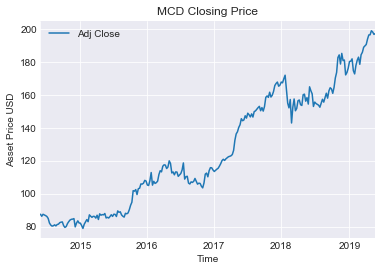

In [5]:
data_MCD = GetData('MCD')
#data_JPM = GetData('JPM')
#data_NVDA = GetData('NVDA')
data_MCD.plot()
plt.title('MCD Closing Price')
plt.ylabel('Asset Price USD')
#plt.ylim(0,500)
plt.xlabel('Time')

In [6]:
###Univariate LSTM###

#early stopping patience
patience = 15
#lstm node count
l_nodes = 32

In [7]:
split_date = '2018-01-01'

train = data_MCD[data_MCD.index<split_date]
test = data_MCD[data_MCD.index>=split_date]

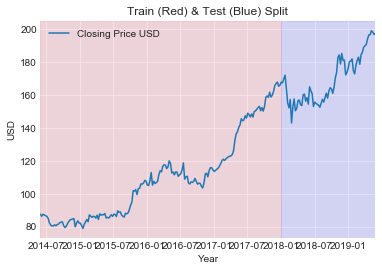

      Training set consists of 72.0% of data


In [8]:
plt.plot(data_MCD, '-', label='By Days')
plt.axvspan(data_MCD.index[0], split_date, color='red', alpha=0.1)
plt.axvspan(split_date, data_MCD.index[-1], color='blue', alpha=0.1)
plt.xlim(data_MCD.index[0],data_MCD.index[-1])
plt.title('Train (Red) & Test (Blue) Split')
plt.legend(['Closing Price USD'])
plt.xlabel('Year')
plt.ylabel('USD')

plt.show()
print('      Training set consists of {}% of data'.format(round(train.shape[0]/data_MCD.shape[0],2)*100))


In [9]:
#NN need values between 0-1
mm = MinMaxScaler()

#mm scalers need to match in shape
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

test = np.reshape(test.values, (len(test),1))
test = mm.transform(test)

#here we are predicting Q days ahead
Q = 1
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

X_test = test[0:len(test)-Q]
y_test = test[Q:len(test)]

X_train = np.reshape(X_train, (len(X_train), 1, X_train.shape[1]))
X_test = np.reshape(X_test, (len(X_test), 1, X_test.shape[1]))

In [10]:
Uni_LSTM = 'reset'
# design network
Uni_LSTM = Sequential()
Uni_LSTM.add(LSTM(l_nodes, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
Uni_LSTM.add(Dense(1))
Uni_LSTM.compile(optimizer='adam', loss='mae')
# fit network
history_uni = Uni_LSTM.fit(X_train, y_train, batch_size=1, epochs=100, 
                           validation_data=(X_test, y_test), callbacks = [EarlyStopping(monitor='val_loss', patience=patience)],
                          verbose=-1)

W0814 00:49:08.306949 4673492416 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0814 00:49:08.332605 4673492416 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0814 00:49:08.334898 4673492416 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0814 00:49:08.556144 4673492416 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0814 00:49:08.692734 4673492416 deprecation.py:323] From //anaconda3/li

Train on 186 samples, validate on 73 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100


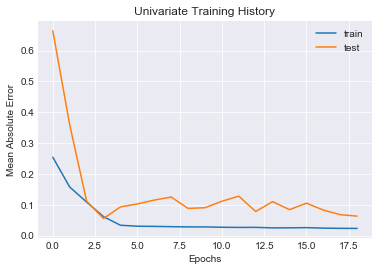

In [11]:
# plot history
plt.plot(history_uni.history['loss'], label='train')
plt.plot(history_uni.history['val_loss'], label='test')
plt.title('Univariate Training History')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [12]:
#finding predictions for test set
predicted_uni = Uni_LSTM.predict(X_test)
predicted_uni = mm.inverse_transform(predicted_uni)[:,0]

y_true = mm.inverse_transform(y_test)

In [13]:
#building dataframe of predictions
pred = pd.DataFrame({'True':y_true.flatten(),'Pred_Uni':predicted_uni.flatten()})
pred.index = data_MCD[data_MCD.index>=split_date][:-1].index

In [14]:
#percent change per day, difference between
pct_ch = pred.pct_change()[1:]
pct_ch = pct_ch[1:]
pct_ch['Uni'] = pct_ch['True'] - pct_ch['Pred_Uni']
pct_ch['Tr'] = 0
pct_ch.index = data_MCD[data_MCD.index>=split_date][1:-2].index

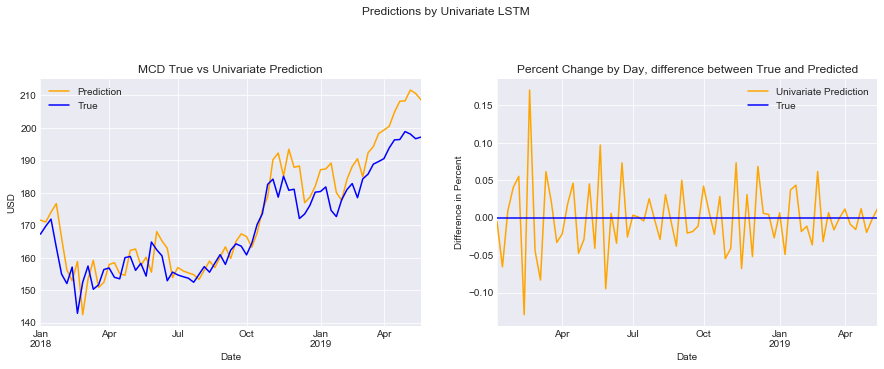

In [22]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('Predictions by Univariate LSTM')

plt.subplot(221)
pred.Pred_Uni.plot(c='orange')
pred['True'].plot(c='blue')
plt.legend(['Prediction','True'])
plt.title('MCD True vs Univariate Prediction')
plt.ylabel('USD')
plt.xlabel('Date')

plt.subplot(222)
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
pct_ch.Uni.plot(c='orange')
pct_ch.Tr.plot(c= 'blue')
plt.legend(['Univariate Prediction','True']);
plt.show()

In [16]:
##MULTIVARIATE LSTM##

In [28]:
#NN need values between 0-1
mm = MinMaxScaler()

#mm scalers need to match in shape
#train = np.reshape(train.values, (train.shape[0], train.shape[1]))
#train = mm.fit_transform(train)

#test = np.reshape(test.values, (test.shape[0], test.shape[1]))
#test = mm.transform(test)

sc = MinMaxScaler(feature_range=(0,1))
a0 = np.array(train)
a1 = np.array(test)
a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
train_MCD = sc.fit_transform(a0)
test_MCD = sc.fit_transform(a1)
scalerJPM = sc

#here we are predicting Q days ahead
Q = 1
X_train = train_MCD[0:len(train)-Q]
y_train = train_MCD[:,0][Q:len(train)] #0th column is the opening on the next day

X_test = test_MCD[0:len(test)-Q]
y_test = test_MCD[:,0][Q:len(test)]

#reshaping all data
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
y_train = np.reshape(y_train, (y_train.shape[0],1))

X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_test = np.reshape(y_test, (y_test.shape[0],1))

In [29]:
Multi_LSTM = 'reset'

# design network
Multi_LSTM = Sequential()
Multi_LSTM.add(LSTM(l_nodes, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
Multi_LSTM.add(Dense(1))
Multi_LSTM.compile(optimizer='adam', loss='mae')

# fit network
history_multi = Multi_LSTM.fit(X_train, y_train, batch_size=1, epochs=100, 
                           validation_data=(X_test, y_test),callbacks = [EarlyStopping(monitor='val_loss', patience=patience)],
                               verbose=-1)

Train on 186 samples, validate on 73 samples
Epoch 1/100
Epoch 2/100
Epoch 3/100
Epoch 4/100
Epoch 5/100
Epoch 6/100
Epoch 7/100
Epoch 8/100
Epoch 9/100
Epoch 10/100
Epoch 11/100
Epoch 12/100
Epoch 13/100
Epoch 14/100
Epoch 15/100
Epoch 16/100
Epoch 17/100
Epoch 18/100
Epoch 19/100
Epoch 20/100
Epoch 21/100
Epoch 22/100
Epoch 23/100
Epoch 24/100
Epoch 25/100
Epoch 26/100
Epoch 27/100
Epoch 28/100
Epoch 29/100
Epoch 30/100
Epoch 31/100
Epoch 32/100
Epoch 33/100
Epoch 34/100
Epoch 35/100
Epoch 36/100
Epoch 37/100
Epoch 38/100
Epoch 39/100
Epoch 40/100
Epoch 41/100
Epoch 42/100
Epoch 43/100
Epoch 44/100
Epoch 45/100
Epoch 46/100
Epoch 47/100
Epoch 48/100
Epoch 49/100
Epoch 50/100
Epoch 51/100
Epoch 52/100
Epoch 53/100
Epoch 54/100
Epoch 55/100
Epoch 56/100
Epoch 57/100
Epoch 58/100


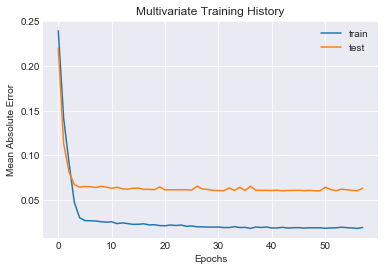

In [30]:
# plot training history
plt.plot(history_multi.history['loss'], label='train')
plt.plot(history_multi.history['val_loss'], label='test')
plt.title('Multivariate Training History')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

In [33]:
#predicting the values of test set
mm2 = MinMaxScaler()
train = data_MCD[data_MCD.index<split_date]
temp = np.reshape(train['open'].values,(train['open'].shape[0],1)).copy()
mm2.fit(temp)


predicted_multi = Multi_LSTM.predict(X_test)
predicted_multi = mm2.inverse_transform(predicted_multi)[:,0]
pred['Pred_Multi'] = predicted_multi.flatten()

#percent change per day, difference between
pct_ch2 = pred['Pred_Multi'].pct_change()[1:]
pct_ch['Pred_Multi'] = pct_ch2[1:]
pct_ch['Multi'] = pct_ch['True'] - pct_ch['Pred_Multi']

NotFittedError: This MinMaxScaler instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

AttributeError: 'DataFrame' object has no attribute 'Pred_Multi'

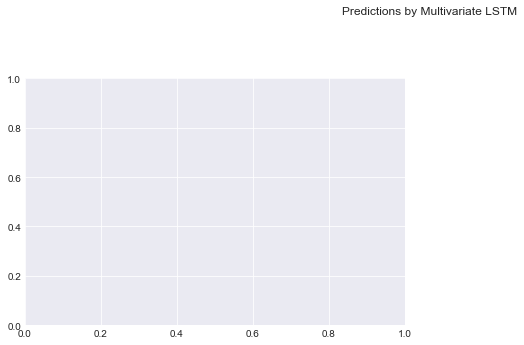

In [32]:
fig = plt.figure(figsize=[15, 10])
plt.suptitle('Predictions by Multivariate LSTM')

plt.subplot(221)
pred.Pred_Multi.plot(c='red')
pred['True'].plot(c='blue')
plt.legend(['Prediction', 'True'])
plt.title('MCD True vs Multivariate Prediction')
plt.ylabel('USD')
plt.xlabel('Date')

plt.subplot(222)
plt.title('Percent Change by Day, difference between True and Predicted')
plt.ylabel('Difference in Percent')
plt.xlabel('Date')
pct_ch.Multi.plot(c='red')
pct_ch.Tr.plot(c='blue')
plt.legend(['Multivariate Prediction','True'])
plt.show()

In [ ]:
#data_ = {}
#for i in asset_list:
#    data_+[i] = GetData(i)

In [ ]:
#train_ = {}
#test_ = {}

#for i in asset_list:
 #   train_[i]= {}
  #  test_[i] = {}
   # train_[i]['Train'], test_[i]['Test'] = i[0:int(len(i)*0.8)], i[int(len(i)*0.8):]


In [ ]:
#Divide data into training and testing
train_data_JPM, test_data_JPM = data_JPM[0:int(len(data_JPM)*0.8)], data_JPM[int(len(data_JPM)*0.8):]
#plt.figure(figsize=(12,7))
plt.title('JPM Prices')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.plot(train_data_JPM['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data_JPM['Adj Close'], 'orange', label='Testing Data')
plt.legend()

In [ ]:
#Divide data into training and testing
train_data_MCD, test_data_MCD = data_MCD[0:int(len(data_MCD)*0.8)], data_MCD[int(len(data_MCD)*0.8):]
#plt.figure(figsize=(12,7))
plt.title('MCD Prices')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.plot(train_data_MCD['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data_MCD['Adj Close'], 'orange', label='Testing Data')
plt.legend()

In [ ]:
#Divide data into training and testing
train_data_NVDA, test_data_NVDA = data_NVDA[0:int(len(data_NVDA)*0.8)], data_NVDA[int(len(data_NVDA)*0.8):]
#plt.figure(figsize=(12,7))
plt.title('NVDA Prices')
plt.xlabel('Dates')
plt.ylabel('Price USD')
plt.plot(train_data_NVDA['Adj Close'], 'blue', label='Training Data')
plt.plot(test_data_NVDA['Adj Close'], 'orange', label='Testing Data')
plt.legend()

In [ ]:
#Scale data

sc = MinMaxScaler(feature_range=(0,1))
a0 = np.array(train_data_JPM['Adj Close'])
a1 = np.array(test_data_JPM['Adj Close'])
a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
transform_train_JPM = sc.fit_transform(a0)
transform_test_JPM = sc.fit_transform(a1)
scalerJPM = sc


In [ ]:
#Scale data

sc = MinMaxScaler(feature_range=(0,1))
a0 = np.array(train_data_NVDA['Adj Close'])
a1 = np.array(test_data_NVDA['Adj Close'])
a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
transform_train_NVDA = sc.fit_transform(a0)
transform_test_NVDA = sc.fit_transform(a1)
scalerNVDA = sc

In [ ]:
#Scale data

sc = MinMaxScaler(feature_range=(0,1))
a0 = np.array(train_data_MCD['Adj Close'])
a1 = np.array(test_data_MCD['Adj Close'])
a0 = a0.reshape(a0.shape[0],1)
a1 = a1.reshape(a1.shape[0],1)
transform_train_MCD = sc.fit_transform(a0)
transform_test_MCD = sc.fit_transform(a1)
scaler_MCD = sc